In [1]:
import pandas as pd
import numpy as np
import random
from scipy.stats import zscore

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define number of records
num_records = 50000  # Generating 50,000 records

# Generate random client IDs
client_ids = [f'C{i:05d}' for i in range(1, num_records + 1)]
account_types = random.choices(["Standard", "VIP", "Premium"], k=num_records)
payment_methods = random.choices(["Credit Card", "Crypto", "Bank Transfer", "E-Wallet"], k=num_records)

# Define high-risk and other countries
high_risk_countries = ["Nigeria", "Pakistan", "Bangladesh", "India", "Vietnam"]
other_countries = [
    "USA", "Canada", "UK", "Germany", "France", "Australia", "Japan", "Spain", "Italy", "Netherlands",
    "Brazil", "South Korea", "Russia", "Mexico", "South Africa", "Malaysia", "Thailand", "Philippines"
]

# Generate synthetic financial data
deposit_amounts = np.random.randint(100, 50000, num_records)
withdrawal_amounts = np.random.randint(0, deposit_amounts)
num_trades = np.random.randint(0, 50, num_records)
avg_trade_amounts = np.random.randint(1, 1000, num_records)
trade_durations = np.random.randint(1, 600, num_records)
total_profits = np.random.randint(-5000, 10000, num_records)
fees_paid = np.round(deposit_amounts * np.random.uniform(0.001, 0.02, num_records), 2)

# **📌 Step 1: Create DataFrame**
df = pd.DataFrame({
    "client_id": client_ids,
    "account_type": account_types,
    "deposit_amount": deposit_amounts,
    "withdrawal_amount": withdrawal_amounts,
    "num_trades": num_trades,
    "avg_trade_amount": avg_trade_amounts,
    "trade_duration": trade_durations,
    "total_profit": total_profits,
    "fees_paid": fees_paid,
    "payment_method": payment_methods
})

# **📌 Step 2: Compute Percentile Scores**
df["deposit_percentile"] = df["deposit_amount"].rank(pct=True) * 100
df["withdrawal_percentile"] = df["withdrawal_amount"].rank(pct=True) * 100
df["num_trades_percentile"] = df["num_trades"].rank(pct=True) * 100
df["trade_duration_percentile"] = df["trade_duration"].rank(pct=True) * 100
df["profit_percentile"] = df["total_profit"].rank(pct=True) * 100

# **📌 Step 3: Calculate Dynamic Risk Score**
df["risk_score"] = (
    (df["withdrawal_percentile"] * 0.3) +   # High withdrawal relative to deposit is risky
    ((100 - df["num_trades_percentile"]) * 0.2) +  # Fewer trades = riskier
    ((100 - df["trade_duration_percentile"]) * 0.2) +  # Shorter trade duration = riskier
    ((df["deposit_percentile"]) * 0.2) +  # Large deposits might be risky
    ((100 - df["profit_percentile"]) * 0.1)  # Low or negative profit might be risky
)

# **📌 Step 4: Adjust Risk Level to Follow Real-World Fraud Distribution**
def assign_risk_level(score):
    if score >= np.percentile(df["risk_score"], 95):  # Top 5% are High Risk
        return "High Risk"
    elif score >= np.percentile(df["risk_score"], 85):  # Next 10% are Medium Risk
        return "Medium Risk"
    elif score >= np.percentile(df["risk_score"], 70):  # Next 15% are Low Risk
        return "Low Risk"
    else:
        return "No Risk"  # Remaining 70%

df["risk_level"] = df["risk_score"].apply(assign_risk_level)

# **📌 Step 5: Assign Country Based on Risk Level**
def assign_country(risk_level):
    if risk_level == "High Risk":
        # 98% chance to be in high-risk countries, 2% in other countries
        high_risk_weight = [98 / len(high_risk_countries)] * len(high_risk_countries)
        other_weight = [2 / len(other_countries)] * len(other_countries)
        combined_countries = high_risk_countries + other_countries
        combined_weights = high_risk_weight + other_weight
        return random.choices(combined_countries, weights=combined_weights, k=1)[0]
    else:
        return random.choice(other_countries)

df["country"] = df["risk_level"].apply(assign_country)

# Save dataset
df.to_csv("fraud_data.csv", index=False)

# Display first few rows
df.head()


,client_id,account_type,deposit_amount,withdrawal_amount,num_trades,avg_trade_amount,trade_duration,total_profit,fees_paid,payment_method,deposit_percentile,withdrawal_percentile,num_trades_percentile,trade_duration_percentile,profit_percentile,risk_score,risk_level,country
0,C00001,VIP,15895,11398,12,306,330,-1611,315.05,E-Wallet,32.017,56.480,25.049,55.486,22.514,54.9890,No Risk,Thailand
1,C00002,Standard,960,502,10,457,108,-2462,15.97,Bank Transfer,1.652,5.423,20.933,17.921,16.864,42.5001,No Risk,Japan
2,C00003,Standard,38258,16044,26,798,214,1122,478.07,Credit Card,76.863,68.536,53.138,36.024,40.923,64.0087,Low Risk,Germany
3,C00004,Standard,44832,21772,1,762,273,6963,753.85,Bank Transfer,89.657,80.016,3.118,46.034,79.815,74.1243,Medium Risk,Japan
4,C00005,Premium,11384,7900,39,546,548,-1632,111.81,Credit Card,22.826,44.876,78.980,91.540,22.376,31.6864,No Risk,Netherlands


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
deposit_amount,50000.0,24885.976300,14383.595607,101.0000,12442.00000,24631.50000,37333.00000,49999.0000
withdrawal_amount,50000.0,12487.174100,10991.702497,0.0000,3421.00000,9301.00000,19043.25000,49643.0000
num_trades,50000.0,24.470300,14.440284,0.0000,12.00000,24.00000,37.00000,49.0000
avg_trade_amount,50000.0,499.964500,288.436843,1.0000,249.00000,500.00000,750.00000,999.0000
trade_duration,50000.0,298.424220,172.831980,1.0000,148.00000,297.00000,448.00000,599.0000
total_profit,50000.0,2492.849540,4326.381337,-5000.0000,-1233.25000,2465.50000,6233.25000,9999.0000
fees_paid,50000.0,261.744629,218.766061,0.1600,81.75000,201.94500,392.96750,995.1600
deposit_percentile,50000.0,50.001000,28.867802,0.0020,25.00100,50.00200,75.00100,100.0000
withdrawal_percentile,50000.0,50.001000,28.867802,0.0090,25.00000,50.00000,75.00125,100.0000
num_trades_percentile,50000.0,50.001000,28.862014,1.0550,25.04900,49.17200,75.00500,99.0020


In [2]:
df['risk_score'].unique()

array([54.989 , 42.5001, 64.0087, ..., 62.6746, 81.868 , 63.3448],
      shape=(48968,))

In [3]:
df['risk_level'].value_counts()

risk_level
No Risk        35000
Low Risk        7500
Medium Risk     5000
High Risk       2500
Name: count, dtype: int64

In [4]:
df[df['risk_level'] == 'High Risk']['country'].value_counts()


country
India           505
Pakistan        498
Bangladesh      492
Vietnam         491
Nigeria         471
UK                7
Canada            4
Italy             4
Japan             3
Australia         3
Germany           3
Malaysia          3
Brazil            3
France            2
Russia            2
Spain             2
Philippines       2
USA               2
South Africa      1
Mexico            1
Netherlands       1
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   client_id                  50000 non-null  object 
 1   account_type               50000 non-null  object 
 2   deposit_amount             50000 non-null  int32  
 3   withdrawal_amount          50000 non-null  int32  
 4   num_trades                 50000 non-null  int32  
 5   avg_trade_amount           50000 non-null  int32  
 6   trade_duration             50000 non-null  int32  
 7   total_profit               50000 non-null  int32  
 8   fees_paid                  50000 non-null  float64
 9   payment_method             50000 non-null  object 
 10  deposit_percentile         50000 non-null  float64
 11  withdrawal_percentile      50000 non-null  float64
 12  num_trades_percentile      50000 non-null  float64
 13  trade_duration_percentile  50000 non-null  flo

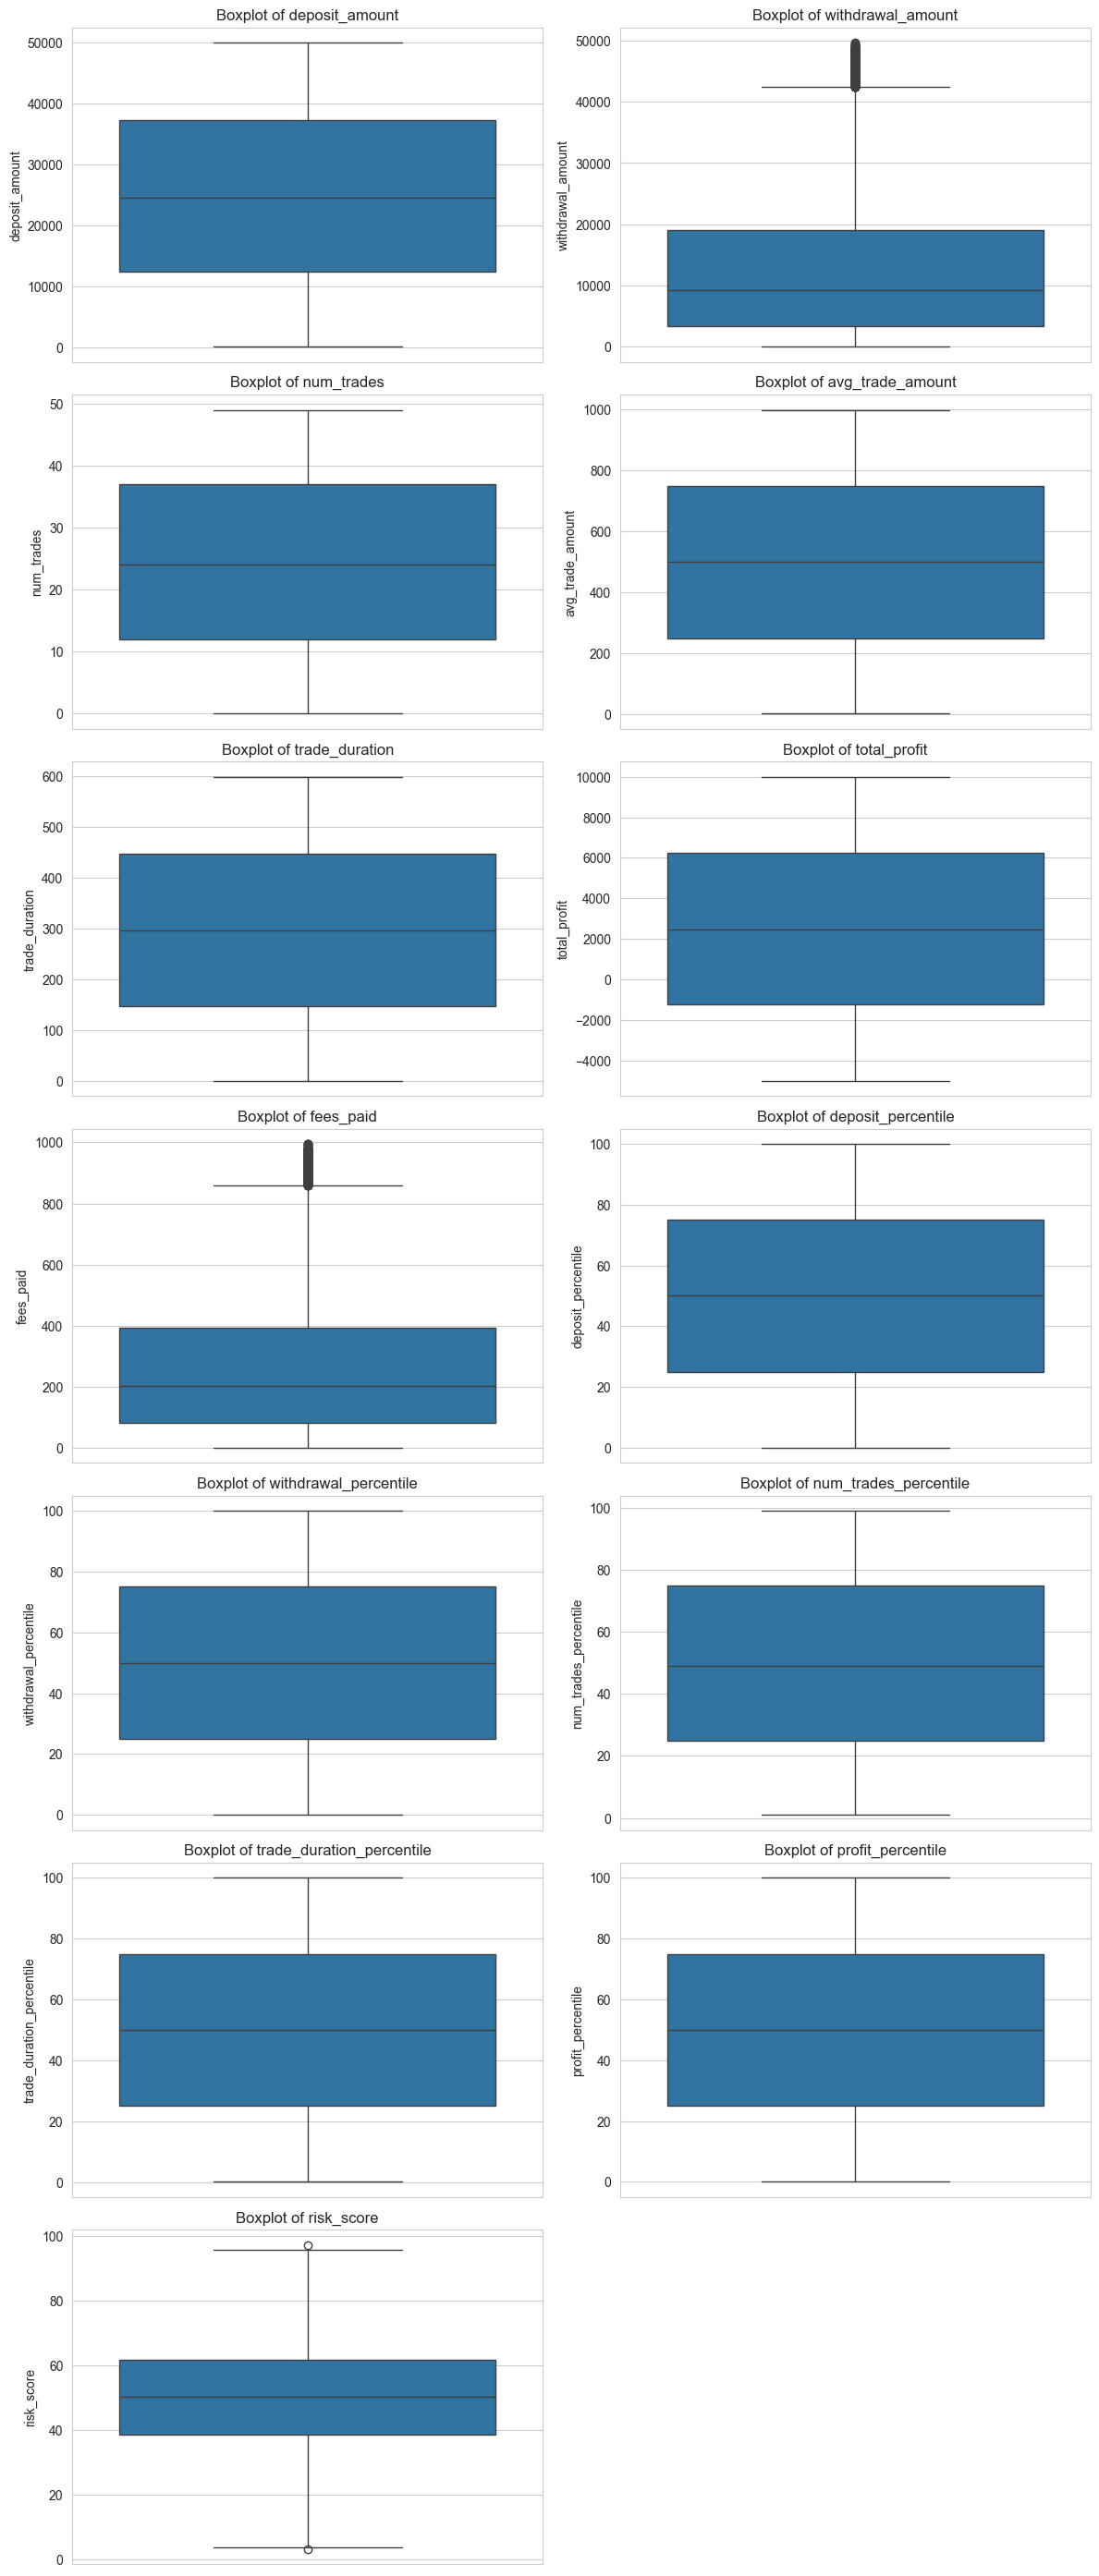

In [10]:
# Select numerical columns (integer and float)
columns_to_plot = df.select_dtypes(include=['number']).columns

# Determine the number of subplots dynamically
num_cols = len(columns_to_plot)
rows = (num_cols // 2) + (num_cols % 2)  # Adjust rows for odd numbers

# Set plot style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 4 * rows))

# Create boxplots
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(rows, 2, i)
    sns.boxplot(y=df[column])
    plt.title(f"Boxplot of {column}")

# Adjust layout
plt.tight_layout()
plt.show()